In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import pandas as pd
import openturns as ot
print(f"Using device: {device}")
import pyvinecopulib as pv
from scipy.stats import gaussian_kde
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [42]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"
with open(dir_out + f'financial_data.npy', 'rb') as f:
    samples_origin = np.load(f)

thres_origin = np.quantile(samples_origin, 0.95,axis=0)
# cond = (samples_origin[:,0] > thres[0] ) 
# for i in range(1, samples_origin.shape[1]):
#     cond |= samples_origin[:,i] > thres[i]
cond = np.any(samples_origin > thres_origin, axis =1)
    
samples = samples_origin[cond,:]

thres = thres_origin.reshape(1,-1)
samples = samples - thres
print(samples.shape)

(100, 5)


In [3]:
samples_origin.shape

(1010, 5)

Text(0.5, 1.0, 'lambda')

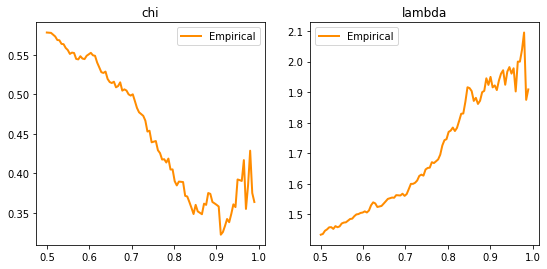

In [ ]:
def empirical_conditional_tail_dependence(X, p, cond = 'and'):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = X[:,0] > quantile[0]
    if cond == 'and':
        for j in range(1,X.shape[1]):
            joint_exceedance &= X[:,j] > quantile[j]
    else:
        for j in range(1,X.shape[1]):
            joint_exceedance |= X[:,j] > quantile[j]
        
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    joint_exceedance = np.sum(joint_exceedance)
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u
probs = np.linspace(0.50, 0.99, 100)
chi_emp = [empirical_conditional_tail_dependence(samples_origin, p, 'and') for p in probs]
plt.figure(figsize=(9,9))
plt.subplot(2, 2, 1)
ax = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax.set_title('chi')
# plt.ylim(0, 1)

chi_emp = [empirical_conditional_tail_dependence(samples_origin, p, 'or') for p in probs]
plt.subplot(2, 2, 2)
ax = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax.set_title('omega')



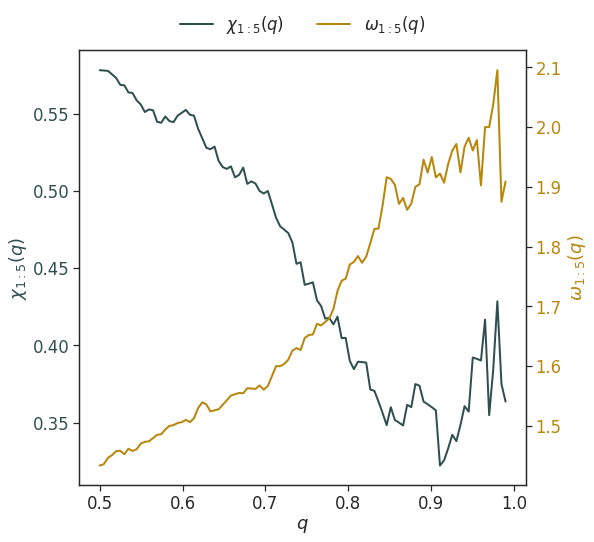

In [259]:
probs = np.linspace(0.50, 0.99, 100)
chi_emp   = [empirical_conditional_tail_dependence(samples_origin, p, 'and') for p in probs]
omega_emp = [empirical_conditional_tail_dependence(samples_origin, p, 'or') for p in probs]

# Create a figure and axis
sns.set(style="ticks",font_scale=1.5)
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot chi (for 'and') on the left y-axis
color_chi = 'darkslategray'
ax1.plot(probs, chi_emp, color=color_chi, linewidth=2, label=r'$\chi_{1:5}(q)$')
ax1.set_xlabel(r'$q$')
ax1.set_ylabel(r'$\chi_{1:5}(q)$', color=color_chi)
ax1.tick_params(axis='y', labelcolor=color_chi)

# Create a twin axis for omega (for 'or')
ax2 = ax1.twinx()
color_omega = 'darkgoldenrod'
ax2.plot(probs, omega_emp, color=color_omega, linewidth=2, label=r'$\omega_{1:5}(q)$')
ax2.set_ylabel(r'$\omega_{1:5}(q)$', color=color_omega)
ax2.tick_params(axis='y', labelcolor=color_omega)

# Add vertical dotted lines at x=0.5 and x=0.7
# for x_val in [0.5, 0.7]:
#     ax1.axvline(x=x_val, color='gray', linestyle='--')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
plt.savefig(dir_out + 'Plots/'+'threshold_selection.pdf',bbox_inches='tight')
plt.show()

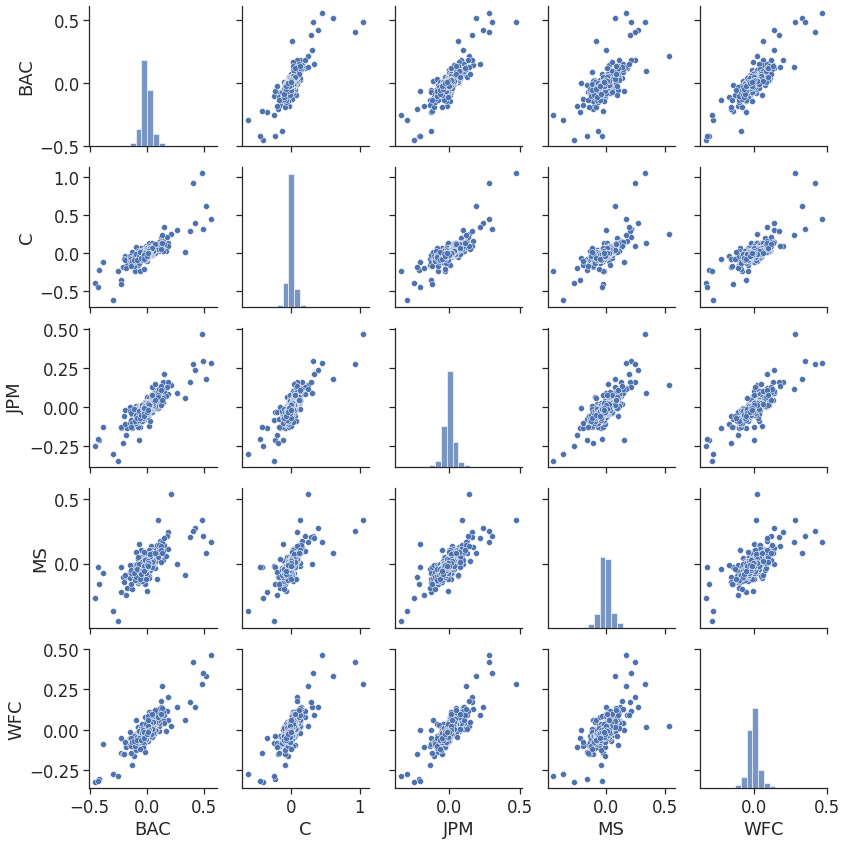

In [94]:
df = pd.DataFrame(samples_origin)
df.columns = ['BAC','C','JPM','MS','WFC']
sns.set(style="ticks",font_scale=1.5)
# fig, ax1 = plt.subplots(figsize=(8, 8))
g = sns.pairplot(df, diag_kws={'bins': 20})
g.fig.set_size_inches(12, 12)
plt.savefig(dir_out + 'Plots/'+'neg_log_return.pdf',bbox_inches='tight')
plt.show()


In [7]:
data = torch.tensor(samples, dtype=torch.float, device = device)
memory = torch.cuda.memory_allocated(device) /10**9
print('{:.2f}G GPU memory allocated'.format(memory))

0.00G GPU memory allocated


In [8]:
dim = 5

base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)


num_layers = 16
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4* latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

# f_T_model.sample(num_samples=2 ** 7)
# z_np = z.to('cpu').data.numpy()
# plt.figure(figsize=(15, 15))
# plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
# plt.gca().set_aspect('equal', 'box')
# plt.show()

batch_size = 64
loss_history = []
epochs = 200

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=100000,fix_margin=False)


optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )
# for name, param in model.named_parameters():
#     print(name, param)



Epoch 1/200, Loss: 0.5743
Epoch 0 - Learning Rate: 0.01


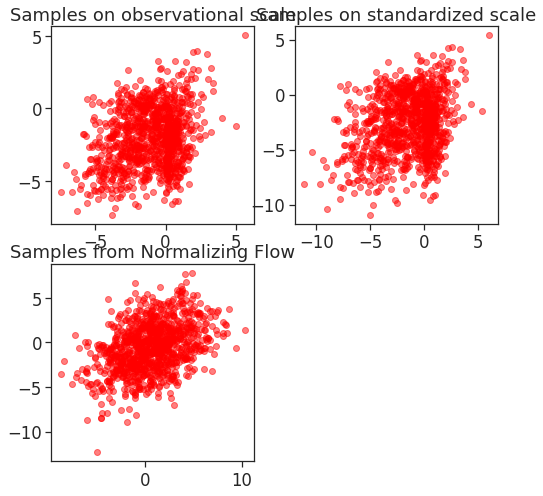

Epoch 2/200, Loss: 0.3417
Epoch 1 - Learning Rate: 0.009999383162408303
Epoch 3/200, Loss: 0.1491
Epoch 2 - Learning Rate: 0.009997532801828657
Epoch 4/200, Loss: -0.0550
Epoch 3 - Learning Rate: 0.00999444937480985
Epoch 5/200, Loss: -0.1525
Epoch 4 - Learning Rate: 0.009990133642141357
Epoch 6/200, Loss: -0.0263
Epoch 5 - Learning Rate: 0.009984586668665639
Epoch 7/200, Loss: 0.2192
Epoch 6 - Learning Rate: 0.009977809823015398
Epoch 8/200, Loss: 0.0641
Epoch 7 - Learning Rate: 0.009969804777275897
Epoch 9/200, Loss: 0.0372
Epoch 8 - Learning Rate: 0.009960573506572387
Epoch 10/200, Loss: -0.0629
Epoch 9 - Learning Rate: 0.009950118288582784
Epoch 11/200, Loss: -0.1575
Epoch 10 - Learning Rate: 0.009938441702975684
Epoch 12/200, Loss: -0.2088
Epoch 11 - Learning Rate: 0.009925546630773864
Epoch 13/200, Loss: -0.2255
Epoch 12 - Learning Rate: 0.009911436253643439
Epoch 14/200, Loss: -0.2699
Epoch 13 - Learning Rate: 0.009896114053108824
Epoch 15/200, Loss: -0.2737
Epoch 14 - Learning 

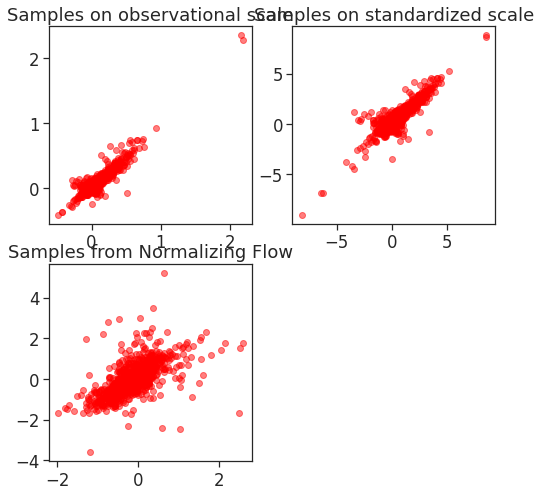

Epoch 52/200, Loss: -0.4493
Epoch 51 - Learning Rate: 0.008479563982961562
Epoch 53/200, Loss: -0.4338
Epoch 52 - Learning Rate: 0.008422735529643434
Epoch 54/200, Loss: -0.4400
Epoch 53 - Learning Rate: 0.008365062567548856
Epoch 55/200, Loss: -0.4480
Epoch 54 - Learning Rate: 0.00830655932661825
Epoch 56/200, Loss: -0.4547
Epoch 55 - Learning Rate: 0.008247240241650909
Epoch 57/200, Loss: -0.4342
Epoch 56 - Learning Rate: 0.00818711994874344
Epoch 58/200, Loss: -0.4438
Epoch 57 - Learning Rate: 0.008126213281678518
Epoch 59/200, Loss: -0.4549
Epoch 58 - Learning Rate: 0.008064535268264873
Epoch 60/200, Loss: -0.4426
Epoch 59 - Learning Rate: 0.008002101126629411
Epoch 61/200, Loss: -0.4550
Epoch 60 - Learning Rate: 0.007938926261462358
Epoch 62/200, Loss: -0.4606
Epoch 61 - Learning Rate: 0.007875026260216385
Epoch 63/200, Loss: -0.4616
Epoch 62 - Learning Rate: 0.007810416889260647
Epoch 64/200, Loss: -0.4538
Epoch 63 - Learning Rate: 0.007745114089990651
Epoch 65/200, Loss: -0.4493

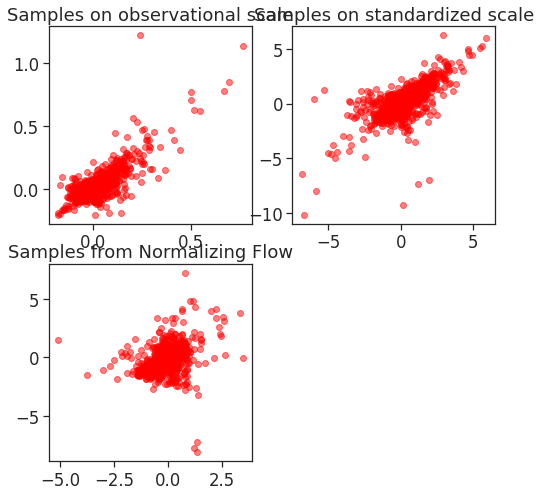

Epoch 102/200, Loss: -0.4951
Epoch 101 - Learning Rate: 0.004921463413440894
Epoch 103/200, Loss: -0.4902
Epoch 102 - Learning Rate: 0.004842946204609355
Epoch 104/200, Loss: -0.4983
Epoch 103 - Learning Rate: 0.004764467746451784
Epoch 105/200, Loss: -0.5007
Epoch 104 - Learning Rate: 0.00468604740235343
Epoch 106/200, Loss: -0.4895
Epoch 105 - Learning Rate: 0.004607704521360773
Epoch 107/200, Loss: -0.4927
Epoch 106 - Learning Rate: 0.0045294584334074255
Epoch 108/200, Loss: -0.4907
Epoch 107 - Learning Rate: 0.004451328444544771
Epoch 109/200, Loss: -0.4771
Epoch 108 - Learning Rate: 0.004373333832178476
Epoch 110/200, Loss: -0.5001
Epoch 109 - Learning Rate: 0.004295493840312086
Epoch 111/200, Loss: -0.4948
Epoch 110 - Learning Rate: 0.004217827674798844
Epoch 112/200, Loss: -0.5012
Epoch 111 - Learning Rate: 0.00414035449860295
Epoch 113/200, Loss: -0.4978
Epoch 112 - Learning Rate: 0.004063093427071376
Epoch 114/200, Loss: -0.4857
Epoch 113 - Learning Rate: 0.003986063523217437


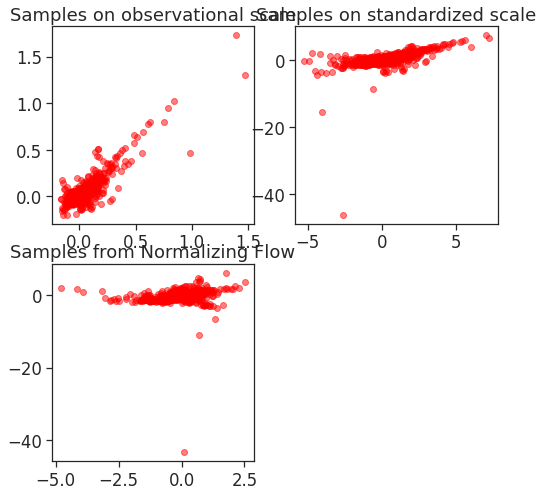

Epoch 152/200, Loss: -0.5267
Epoch 151 - Learning Rate: 0.0014093685111840565
Epoch 153/200, Loss: -0.5317
Epoch 152 - Learning Rate: 0.0013551568628929432
Epoch 154/200, Loss: -0.5298
Epoch 153 - Learning Rate: 0.001301844525106951
Epoch 155/200, Loss: -0.5352
Epoch 154 - Learning Rate: 0.0012494446518477018
Epoch 156/200, Loss: -0.5341
Epoch 155 - Learning Rate: 0.0011979701719998452
Epoch 157/200, Loss: -0.5241
Epoch 156 - Learning Rate: 0.001147433786121054
Epoch 158/200, Loss: -0.5259
Epoch 157 - Learning Rate: 0.001097847963308352
Epoch 159/200, Loss: -0.5289
Epoch 158 - Learning Rate: 0.0010492249381215478
Epoch 160/200, Loss: -0.5299
Epoch 159 - Learning Rate: 0.001001576707564547
Epoch 161/200, Loss: -0.5313
Epoch 160 - Learning Rate: 0.0009549150281252633
Epoch 162/200, Loss: -0.5373
Epoch 161 - Learning Rate: 0.0009092514128748835
Epoch 163/200, Loss: -0.5310
Epoch 162 - Learning Rate: 0.0008645971286271914
Epoch 164/200, Loss: -0.5305
Epoch 163 - Learning Rate: 0.0008209631

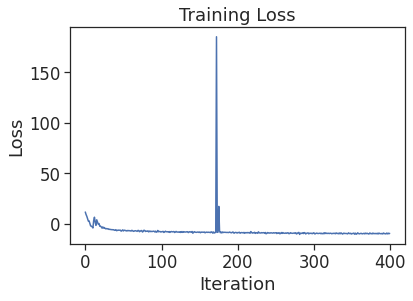

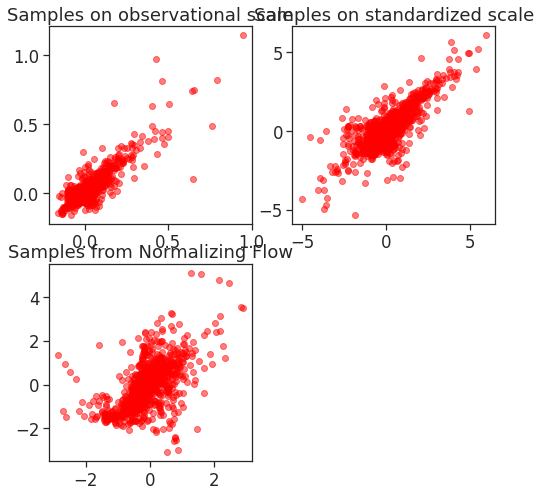

In [9]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10, verbose=True
# )


Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)
        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(x_data):.4f}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Learning Rate: {current_lr}")
    # Debugging: Print shapes

    if epoch % 50 ==0:
        samples_obs, samples_std, samples_T= model.sample(1000)
        plt.figure(figsize=(8,8))
        plt.subplot(2, 2, 1)
        plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on observational scale')
        plt.subplot(2, 2, 2)
        plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on standardized scale')
        plt.subplot(2, 2, 3)
        plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

samples_obs, samples_std, samples_T= model.sample(1000)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

In [10]:
def marginal_density_comparison(data, i, model,n_samples, n_bootstrap):
    margin = data[:,i]  # Example data
    # Step 1: Estimate the KDE of the data and get the KDE values
    kde = gaussian_kde(margin)
    tail_range = ( max(margin) - min(margin))/5
    x_values = np.linspace(min(margin) - tail_range, max(margin) + tail_range, 1000)
    kde_values = kde(x_values)
    
    # Step 2: Generate samples and compute their KDEs
    n_samples = len(margin)
    sample_kdes = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(n_samples)
        sampled_data = samples_obs[:,i].cpu().data.numpy()
        sample_kde = gaussian_kde(sampled_data)
        sample_kde_values = sample_kde(x_values)
        sample_kdes.append(sample_kde_values)
    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_kdes = np.array(sample_kdes)
    mean = np.mean(sample_kdes, axis=0)
    lower_bound = np.percentile(sample_kdes, 2.5, axis=0)
    upper_bound = np.percentile(sample_kdes, 97.5, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the KDE of the data
    sns.lineplot(x=x_values, y=kde_values, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=x_values, y=mean, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
    # sns.lineplot(x=x_values, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=x_values, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)

    # Plot the credible interval as a ribbon
    ax.fill_between(x_values, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')

    ax.set_title('Marignal Density of Dimension {}'.format(i+1), fontsize=14)


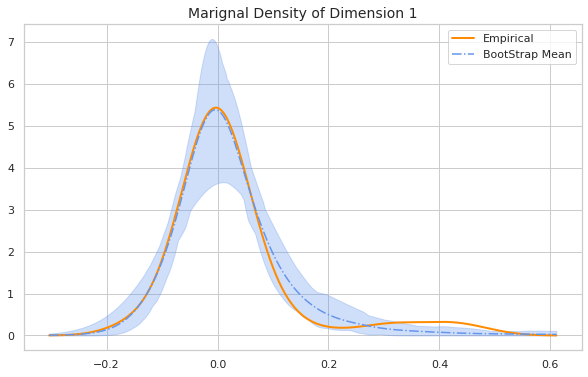

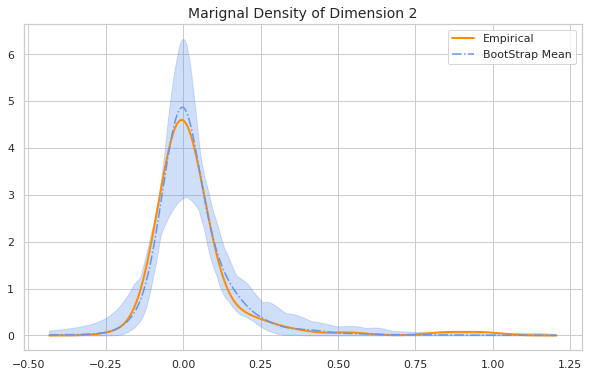

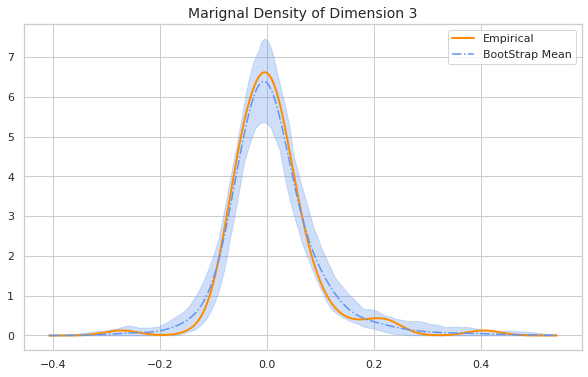

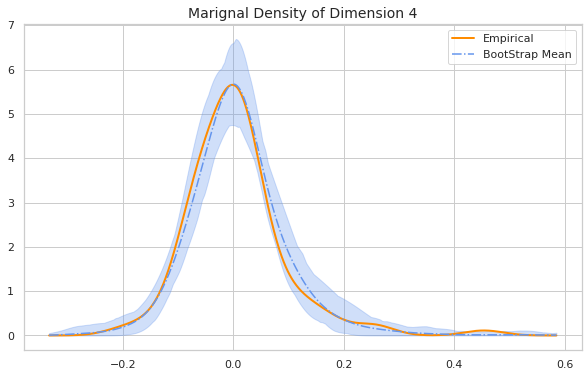

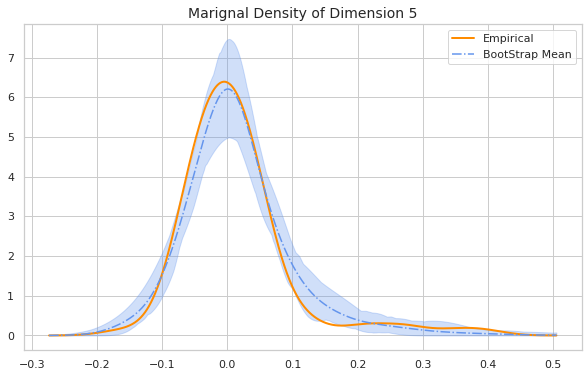

In [11]:
n_bootstrap = 30
marginal_density_comparison(data= samples, i = 0, model=model, n_samples= 10000, n_bootstrap = n_bootstrap)
marginal_density_comparison(data= samples, i = 1, model=model, n_samples= 10000, n_bootstrap = n_bootstrap)
marginal_density_comparison(data= samples, i = 2, model=model, n_samples= 10000, n_bootstrap = n_bootstrap)
marginal_density_comparison(data= samples, i = 3, model=model, n_samples= 10000, n_bootstrap = n_bootstrap)
marginal_density_comparison(data= samples, i = 4, model=model, n_samples= 10000, n_bootstrap = n_bootstrap)

<Axes: >

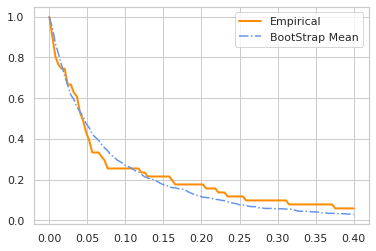

In [12]:
x_value = np.linspace(0,0.4,100)
y_value1 = [np.mean(samples[:,1]>x) for x in x_value]
y_value2 = [np.mean(samples_obs[:,1].cpu().data.numpy()>x) for x in x_value]

y_value1 = [np.mean(samples[:,1]>x)/np.mean(samples[:,1]>0) for x in x_value]
y_value2 = [np.mean(samples_obs[:,1].cpu().data.numpy()>x)/np.mean(samples_obs[:,1].cpu().data.numpy()>0) for x in x_value]

sns.lineplot(x=x_value, y=y_value1, label='Empirical', color='darkorange', linewidth=2)

# Plot the credible intervals
sns.lineplot(x=x_value, y=y_value2, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)

In [34]:
import json
with open(dir_out + "mGPD_pred.json", "r") as f:
    mGPD_pred = json.load(f)
mGPD_pred = [np.array(pred) for pred in mGPD_pred]
mGPD_pred

[array([[ 1.408e-01, -3.990e-02,  1.840e-02, -5.690e-02,  7.520e-02],
        [ 1.270e-02, -2.190e-02, -1.120e-02, -2.350e-02,  1.130e-02],
        [ 1.129e-01,  2.623e-01, -5.670e-02,  2.201e-01,  1.685e-01],
        [-5.330e-02, -5.340e-02,  2.530e-02,  7.510e-02,  5.400e-02],
        [-6.210e-02, -5.160e-02, -1.021e-01,  2.210e-02, -3.100e-02],
        [-5.480e-02,  3.090e-02, -3.990e-02, -3.870e-02,  3.560e-02],
        [-5.000e-02, -4.000e-03,  2.060e-02, -5.900e-03, -7.000e-04],
        [-4.430e-02, -2.200e-03,  0.000e+00, -1.140e-02, -5.080e-02],
        [-2.450e-02, -4.410e-02,  2.870e-02, -4.910e-02,  2.690e-02],
        [-4.360e-02,  9.010e-02,  1.524e-01,  1.860e-01,  1.594e-01],
        [ 5.800e-02, -5.370e-02,  6.690e-02,  6.860e-02, -1.300e-02],
        [-5.390e-02,  8.830e-02, -3.640e-02, -6.710e-02,  5.400e-02],
        [ 2.854e-01,  4.900e-01,  1.352e-01,  1.247e-01,  6.170e-02],
        [ 2.038e-01,  5.300e-03,  1.226e-01,  1.101e-01, -1.310e-02],
        [-6.340e-02,

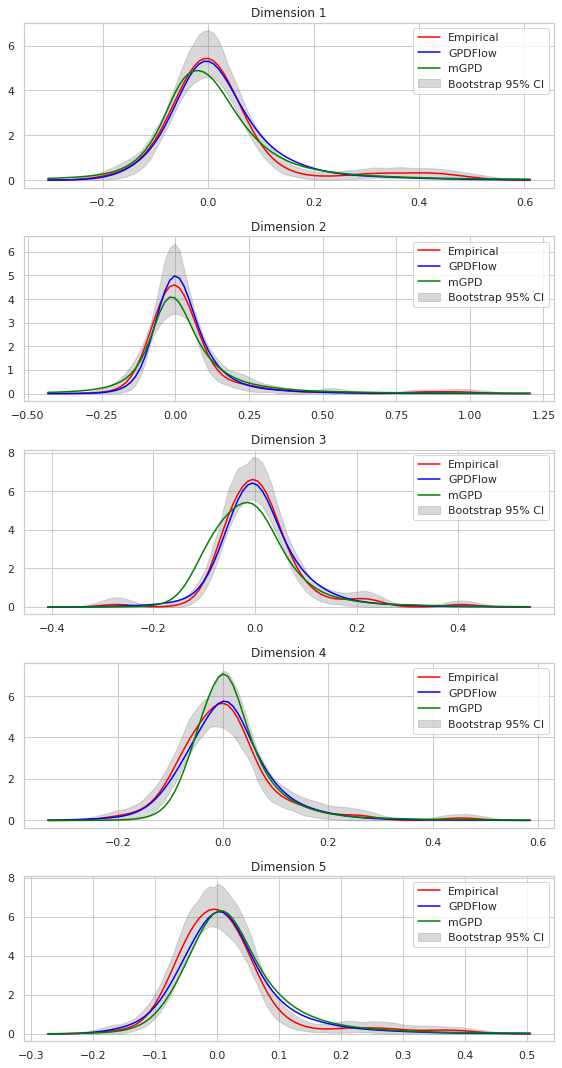

In [37]:

n_bootstrap = 100        # Number of bootstrap samples
n_grid = 100            # Number of points for the KDE grid
dimensions = samples.shape[1]

# Create subplots: one per dimension
fig, axes = plt.subplots(dimensions, 1, figsize=(8, dimensions * 3))

for i in range(dimensions):
    ax = axes[i]
    
    # Define a grid spanning the range of data in dimension i (from all datasets)
    tail_range = ( max(samples[:,i]) - min(samples[:,i]))/5
    x_grid = np.linspace(min(samples[:,i]) - tail_range, max(samples[:,i]) + tail_range, n_grid)
    
    # Estimate KDE for each dataset
    
    
    kde_samples = gaussian_kde(samples[:, i])
    y_samples = kde_samples(x_grid)
    
    # Plot the KDE lines for the three datasets


    ax.plot(x_grid, y_samples, label='Empirical', color='red')
    
    # --- Bootstrapping for the 'samples' dataset ---
    bootstrap_densities = []
    GPDFlow_kdes = []
    mGPD_kdes = []
    for b in range(n_bootstrap):
        # Draw a bootstrap sample (with replacement)
        boot_indices = np.random.choice(len(samples[:, i]), size=len(samples[:, i]), replace=True)
        boot_sample = samples[boot_indices, i]
        
        # Try computing the KDE for the bootstrap sample.
        # (Sometimes the KDE might fail if the sample is degenerate)
        try:
            kde_boot = gaussian_kde(boot_sample)
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        bootstrap_densities.append(y_boot)

        samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
        sampled_data = samples_obs[:,i].cpu().data.numpy()
        sample_kde = gaussian_kde(sampled_data)
        sample_kde_values = sample_kde(x_grid)
        GPDFlow_kdes.append(sample_kde_values)

        mGPD_kde = gaussian_kde(mGPD_pred[b][:,i])
        mGPD_kde_values = mGPD_kde(x_grid)
        mGPD_kdes.append(mGPD_kde_values)
        
        
    
    GPDFlow_kdes = np.array(GPDFlow_kdes)
    GPDFlow_mean = np.mean(GPDFlow_kdes, axis=0)
    ax.plot(x_grid, GPDFlow_mean, label='GPDFlow', color='blue')    
    
    mGPD_kdes = np.array(mGPD_kdes)
    mGPD_mean = np.mean(mGPD_kdes, axis=0)
    ax.plot(x_grid, mGPD_mean, label='mGPD', color='green')
    # Convert to numpy array: shape (n_bootstrap, n_grid)
    bootstrap_densities = np.array(bootstrap_densities)
    
    # Compute the 2.5th and 97.5th percentiles at each x value
    lower_bound = np.percentile(bootstrap_densities, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_densities, 97.5, axis=0)
    
    # Shade the area between the lower and upper bootstrap density curves
    ax.fill_between(x_grid, lower_bound, upper_bound, color='gray', alpha=0.3,
                    label='Bootstrap 95% CI')
    
    ax.set_title(f"Dimension {i+1}")
    ax.legend()

plt.tight_layout()
plt.show()

In [66]:
# ----- Parameters -----
n_bootstrap = 100      # Number of bootstrap replicates
n_grid = 100          # Number of points for the KDE grid
dimensions = samples.shape[1]  # e.g., 5 dimensions

# ----- Bootstrap on the Whole Datasets -----
# We generate bootstrap replicates of the entire 5-D datasets.
bootstrap_samples_origin = []
bootstrap_samples = []    # For the empirical samples (shape: 100×5)
bootstrap_mGPD = mGPD_pred      # For the mGPD predictions (draw 100 rows from mGPD_pred)
bootstrap_GPDFlow = []    # For the GPDFlow predictions (generated on the fly)

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups


for b in range(n_bootstrap):
    # --- Empirical Samples ---
    indices_emp = np.random.choice(samples_origin.shape[0], size=samples_origin.shape[0], replace=True)
    boot_emp = samples_origin[indices_emp, :]  # shape (100, 5)
    bootstrap_samples_origin.append(boot_emp)
    cond = np.any(boot_emp > thres_origin, axis=1)
    boot_emp = boot_emp[cond,:] - thres
    bootstrap_samples.append(boot_emp)
   
    
    # --- mGPD Predictions ---
    # Here we sample 100 rows (with replacement) from the mGPD prediction pool.
    
    # --- GPDFlow Predictions ---
    # Generate new predictions of size (100, 5) using the model's sample method.
    samples_obs, samples_std, samples_T = model.sample(samples.shape[0])
    boot_GPDFlow = samples_obs.cpu().data.numpy()  # Convert to NumPy array
    bootstrap_GPDFlow.append(boot_GPDFlow)




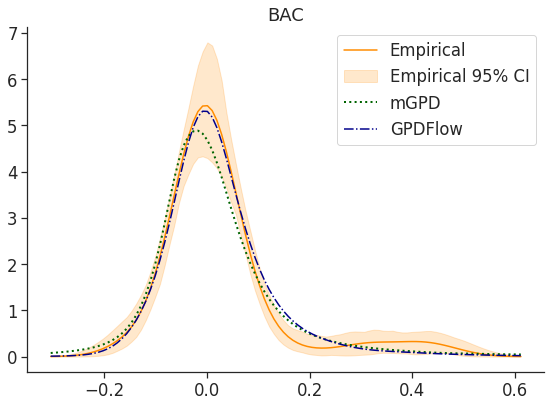

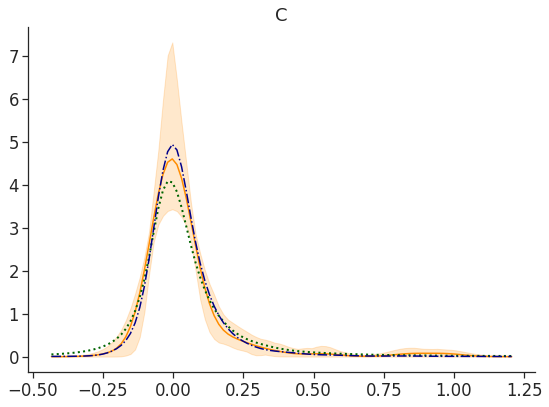

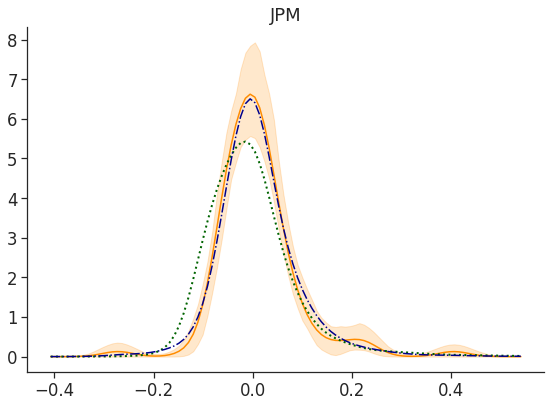

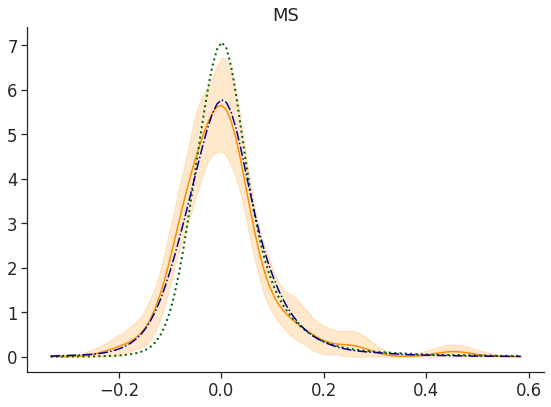

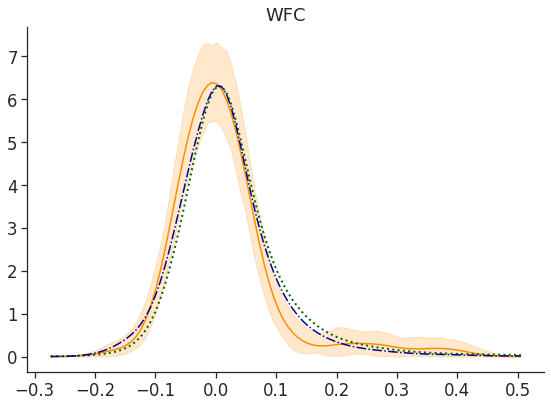

In [ ]:

for i in range(dimensions):
    # Create a separate figure for each dimension
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define an x-grid based on the empirical data in dimension i.
    tail_range = (samples[:, i].max() - samples[:, i].min()) / 5
    x_grid = np.linspace(samples[:, i].min() - tail_range,
                         samples[:, i].max() + tail_range, n_grid)
    
    # --- Empirical KDE (Full Dataset) ---
    kde_emp = gaussian_kde(samples[:, i])
    y_emp = kde_emp(x_grid)
    ax.plot(x_grid, y_emp, label='Empirical', color='darkorange')
    
    # --- Empirical Bootstrap KDEs for 95% CI ---
    kde_emp_boot = []
    for boot in bootstrap_samples:
        try:
            kde_boot = gaussian_kde(boot[:, i])
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        kde_emp_boot.append(y_boot)
    kde_emp_boot = np.array(kde_emp_boot)
    lower_bound = np.percentile(kde_emp_boot, 2.5, axis=0)
    upper_bound = np.percentile(kde_emp_boot, 97.5, axis=0)
    ax.fill_between(x_grid, lower_bound, upper_bound, color='darkorange', alpha=0.2,
                    label='Empirical 95% CI')
    
    # --- mGPD Predictions KDE (Monte Carlo Mean) ---
    kde_mGPD_boot = []
    for boot in bootstrap_mGPD:
        try:
            kde_boot = gaussian_kde(boot[:, i])
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        kde_mGPD_boot.append(y_boot)
    kde_mGPD_boot = np.array(kde_mGPD_boot)
    mGPD_mean = np.mean(kde_mGPD_boot, axis=0)
    ax.plot(x_grid, mGPD_mean, label='mGPD', color='darkgreen', linestyle = 'dotted',lw=2)
    
    # --- GPDFlow Predictions KDE (Monte Carlo Mean) ---
    kde_GPDFlow_boot = []
    for boot in bootstrap_GPDFlow:
        try:
            kde_boot = gaussian_kde(boot[:, i])
            y_boot = kde_boot(x_grid)
        except np.linalg.LinAlgError:
            y_boot = np.zeros_like(x_grid)
        kde_GPDFlow_boot.append(y_boot)
    kde_GPDFlow_boot = np.array(kde_GPDFlow_boot)
    GPDFlow_mean = np.mean(kde_GPDFlow_boot, axis=0)
    ax.plot(x_grid, GPDFlow_mean, label='GPDFlow', color='darkblue',linestyle = 'dashdot')
    
    ax.set_title(f"{df.columns[i]}")
    if i == 0:
        ax.legend()
    sns.despine()
    plt.tight_layout()
    plt.savefig(dir_out + 'Plots/'+f'marginal_density_{i}.pdf',bbox_inches='tight')
    plt.show()


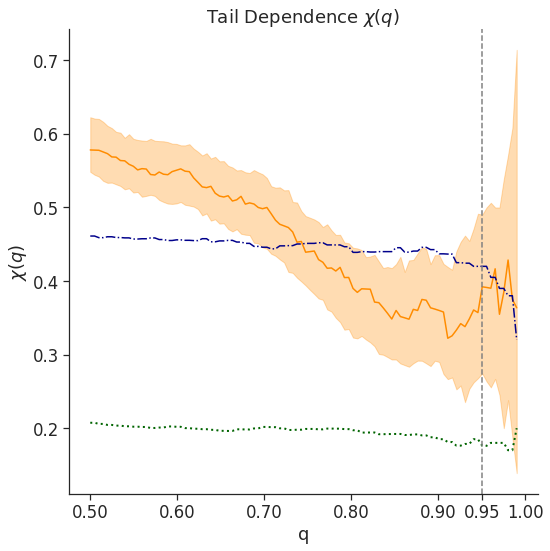

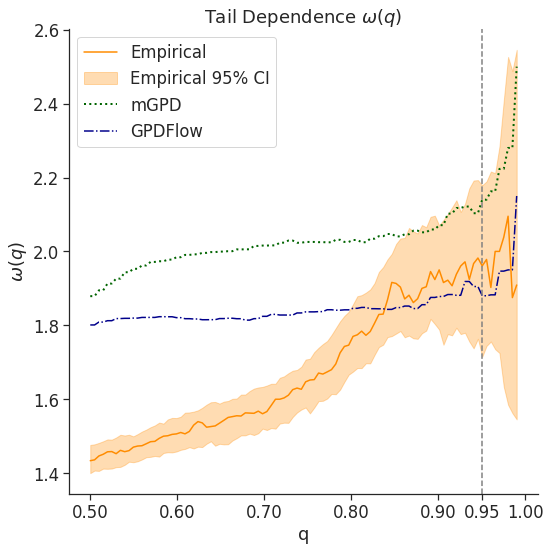

In [95]:
# ----- 2. Tail Dependence Measures via Bootstrap -----
# For a grid of thresholds p in [0.50, 0.99] we compute:
#   - χ (using cond='and')
#   - ω (using cond='or')
#
# For each bootstrap replicate (for each dataset), we calculate the measure.
# Then we plot the Monte Carlo (bootstrap) mean for each dataset.
# For the empirical samples we also add the 95% CI (shaded area).

p_grid = np.linspace(0.50, 0.99, 100)

# Initialize arrays to store the tail dependence measures for each bootstrap replicate.
chi_empirical_boot = np.zeros((n_bootstrap, len(p_grid)))
chi_mGPD_boot      = np.zeros((n_bootstrap, len(p_grid)))
chi_GPDFlow_boot   = np.zeros((n_bootstrap, len(p_grid)))

omega_empirical_boot = np.zeros((n_bootstrap, len(p_grid)))
omega_mGPD_boot      = np.zeros((n_bootstrap, len(p_grid)))
omega_GPDFlow_boot   = np.zeros((n_bootstrap, len(p_grid)))

# Loop over bootstrap replicates and thresholds.
for b in range(n_bootstrap):
    emp_data    = bootstrap_samples_origin[b]
    mGPD_data   = bootstrap_mGPD[b]
    GPDFlow_data= bootstrap_GPDFlow[b]
    for j, p_val in enumerate(p_grid):
        # Compute χ (cond='and')
        chi_empirical_boot[b, j] = empirical_conditional_tail_dependence(emp_data, p_val, cond='and')
        chi_mGPD_boot[b, j]      = empirical_conditional_tail_dependence(mGPD_data, p_val, cond='and')
        chi_GPDFlow_boot[b, j]   = empirical_conditional_tail_dependence(GPDFlow_data, p_val, cond='and')
        
        # Compute ω (cond='or')
        omega_empirical_boot[b, j] = empirical_conditional_tail_dependence(emp_data, p_val, cond='or')
        omega_mGPD_boot[b, j]      = empirical_conditional_tail_dependence(mGPD_data, p_val, cond='or')
        omega_GPDFlow_boot[b, j]   = empirical_conditional_tail_dependence(GPDFlow_data, p_val, cond='or')

# Compute means and 95% CIs for the empirical tail dependence measures
chi_empirical_mean  = np.array(chi_emp)
chi_empirical_lower = np.percentile(chi_empirical_boot, 2.5, axis=0)
chi_empirical_upper = np.percentile(chi_empirical_boot, 97.5, axis=0)

chi_mGPD_mean    = np.mean(chi_mGPD_boot, axis=0)
chi_GPDFlow_mean = np.mean(chi_GPDFlow_boot, axis=0)

omega_empirical_mean  = np.array(omega_emp)
omega_empirical_lower = np.percentile(omega_empirical_boot, 2.5, axis=0)
omega_empirical_upper = np.percentile(omega_empirical_boot, 97.5, axis=0)

omega_mGPD_mean    = np.mean(omega_mGPD_boot, axis=0)
omega_GPDFlow_mean = np.mean(omega_GPDFlow_boot, axis=0)

# ----- Plot Tail Dependence (χ) for cond='and' -----
fig, ax = plt.subplots(figsize=(8, 8))
ticks =  [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
ax.plot(p_grid, chi_empirical_mean, label='Empirical', color='darkorange')
ax.fill_between(p_grid, chi_empirical_lower, chi_empirical_upper, color='darkorange', alpha=0.3,
                label='Empirical 95% CI')
ax.plot(p_grid, chi_mGPD_mean, label='mGPD', color='darkgreen',linestyle = 'dotted',lw=2)
ax.plot(p_grid, chi_GPDFlow_mean, label='GPDFlow', color='darkblue',linestyle = 'dashdot')
ax.axvline(x=0.95, color='gray', linestyle='--')
ax.set_title(r"Tail Dependence $\chi(q)$ ")
ax.set_xlabel('q')
ax.set_ylabel(r'$\chi(q)$')
# ax.legend()
sns.despine()
ax.set_xticks(ticks)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'chi_estimation.pdf',bbox_inches='tight')
plt.show()

# ----- Plot Tail Dependence (ω) for cond='or' -----
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_grid, omega_empirical_mean, label='Empirical', color='darkorange')
ax.fill_between(p_grid, omega_empirical_lower, omega_empirical_upper, color='darkorange', alpha=0.3,
                label='Empirical 95% CI')
ax.plot(p_grid, omega_mGPD_mean, label='mGPD', color='darkgreen',linestyle = 'dotted', lw=2)
ax.plot(p_grid, omega_GPDFlow_mean, label='GPDFlow', color='darkblue',linestyle = 'dashdot')
ax.axvline(x=0.95, color='gray', linestyle='--')
ax.set_title(r"Tail Dependence $\omega(q)$")
ax.set_xlabel('q')
ax.set_ylabel(r'$\omega(q)$')
ax.legend(loc='upper left')
sns.despine()
ax.set_xticks(ticks)
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+'omega_estimation.pdf',bbox_inches='tight')
plt.show()

## CoVaR

In [109]:
CoVaR_samples = samples_origin[samples_origin[:,2]>thres_origin[2],:]

In [191]:
alpha = np.concatenate([np.arange(0.1,1,0.01), np.arange(0.99,0.999,0.001)])
print(alpha)


[0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21
 0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33
 0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45
 0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57
 0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69
 0.7   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81
 0.82  0.83  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93
 0.94  0.95  0.96  0.97  0.98  0.99  0.99  0.991 0.992 0.993 0.994 0.995
 0.996 0.997 0.998 0.999]


In [197]:
CoVaR_emp = np.quantile(CoVaR_samples, alpha, axis=0)

In [198]:
CoVaR_pred_2 = []
for b in range(n_bootstrap):
    boot_GPDFlow = bootstrap_GPDFlow[b]
    CoVaR_pred_2.append(np.quantile(boot_GPDFlow[boot_GPDFlow[:,2]>0,:], alpha, axis=0)+thres )

    samples_origin[samples_origin[:,2]>thres_origin[2],:]

In [202]:
CoVaR_pred_2 = np.array(CoVaR_pred_2)
CoVaR_pred_2_mean = np.mean(CoVaR_pred_2, axis = 0)
CoVaR_pred_2_upp = np.quantile(CoVaR_pred_2, 0.975, axis = 0)
CoVaR_pred_2_low = np.quantile(CoVaR_pred_2, 0.025, axis = 0)

In [207]:
CoVaR_emp.shape

(100, 5)

In [231]:
alpha[:90:5]

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [229]:
alpha

array([0.1  , 0.11 , 0.12 , 0.13 , 0.14 , 0.15 , 0.16 , 0.17 , 0.18 ,
       0.19 , 0.2  , 0.21 , 0.22 , 0.23 , 0.24 , 0.25 , 0.26 , 0.27 ,
       0.28 , 0.29 , 0.3  , 0.31 , 0.32 , 0.33 , 0.34 , 0.35 , 0.36 ,
       0.37 , 0.38 , 0.39 , 0.4  , 0.41 , 0.42 , 0.43 , 0.44 , 0.45 ,
       0.46 , 0.47 , 0.48 , 0.49 , 0.5  , 0.51 , 0.52 , 0.53 , 0.54 ,
       0.55 , 0.56 , 0.57 , 0.58 , 0.59 , 0.6  , 0.61 , 0.62 , 0.63 ,
       0.64 , 0.65 , 0.66 , 0.67 , 0.68 , 0.69 , 0.7  , 0.71 , 0.72 ,
       0.73 , 0.74 , 0.75 , 0.76 , 0.77 , 0.78 , 0.79 , 0.8  , 0.81 ,
       0.82 , 0.83 , 0.84 , 0.85 , 0.86 , 0.87 , 0.88 , 0.89 , 0.9  ,
       0.91 , 0.92 , 0.93 , 0.94 , 0.95 , 0.96 , 0.97 , 0.98 , 0.99 ,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999])

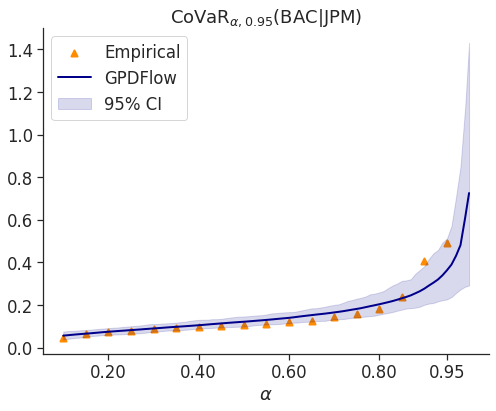

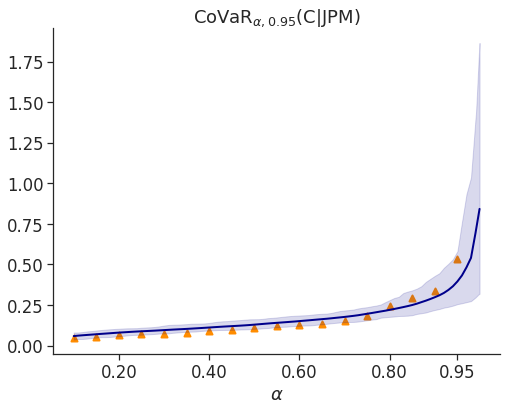

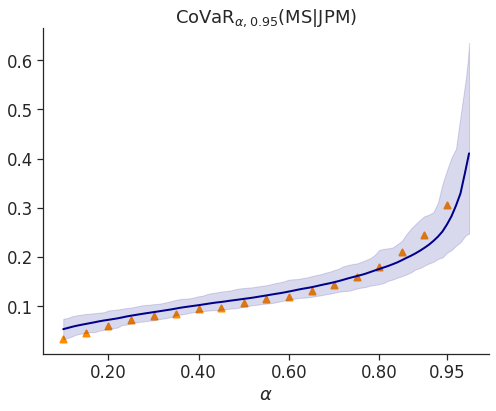

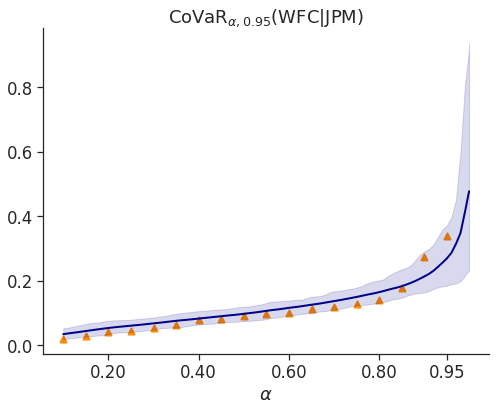

In [256]:
ticks =  [0.2, 0.4, 0.6, 0.8, 0.95]
for j in [0,1,3,4]:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(alpha[:90:5], CoVaR_emp[:90:5,j], label='Empirical', color='darkorange', marker='^', lw=2)
    ax.plot(alpha, CoVaR_pred_2_mean[:,j], label='GPDFlow', color='darkblue', lw=2)
    ax.fill_between(alpha, CoVaR_pred_2_low[:,j], CoVaR_pred_2_upp[:,j], color='darkblue', alpha=0.15,
                        label='95% CI')
    ax.set_title(r"$\text{CoVaR}_{\alpha,0.95}$"+f'({df.columns[j]}|JPM)')
    ax.set_xlabel(r'$\alpha$')
    if j == 0:
        ax.legend(loc='upper left')
    ax.set_xticks(ticks)
    sns.despine()
    plt.savefig(dir_out + 'Plots/'+f'CoVaR({df.columns[j]}_JPM).pdf',bbox_inches='tight')
    plt.show()

In [ ]:
def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate omega_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u

def plot_tail_dependence(data, i, j, model, n_bootstrap):
    probs = np.linspace(0.50, 0.99, 100)
    # Compute omega_u for each quantile
    chi_emp = [empirical_upper_tail_dependence(data[:,[i,j]], p) for p in probs]

    # Step 2: Generate samples and compute their KDEs
    n_samples = data.shape[0]
    sample_chi = []
    
    for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
        samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
        sampled_data = samples_obs.cpu().data.numpy()
        sample_chi.append( [empirical_upper_tail_dependence(sampled_data[:,[i,j]], p) for p in probs])

    
    # Step 3: Calculate the 95% credible interval for the KDE of the samples
    sample_chi = np.array(sample_chi)
    lower_bound = np.percentile(sample_chi, 2.5, axis=0)
    upper_bound = np.percentile(sample_chi, 97.5, axis=0)
    mean = np.mean(sample_chi, axis=0)
    
    # Step 4: Plot the KDE of the data and the credible intervals with Seaborn
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the KDE of the data
    sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
    
    # Plot the credible intervals
    sns.lineplot(x=probs, y=mean, linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
    # sns.lineplot(x=probs, y=lower_bound, linestyle='--', color='cornflowerblue', label='95% BootStrap CI', linewidth=1.5)
    # sns.lineplot(x=probs, y=upper_bound, linestyle='--', color='cornflowerblue', linewidth=1.5)
    ax.fill_between(probs, lower_bound, upper_bound, color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
    
    ax.set_title('Chi Between Dimension {} and {}'.format(i+1,j+1), fontsize=14)

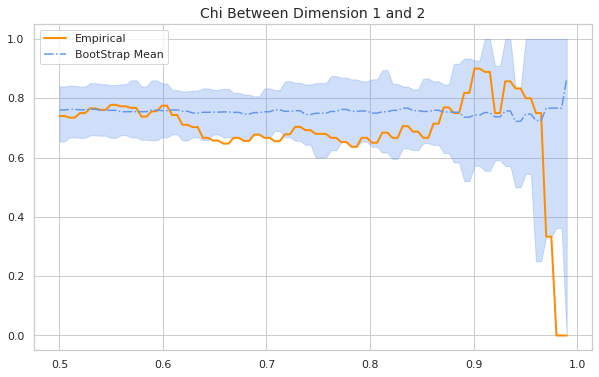

In [208]:
plot_tail_dependence(samples, i=0, j=1, model=model, n_bootstrap= n_bootstrap)

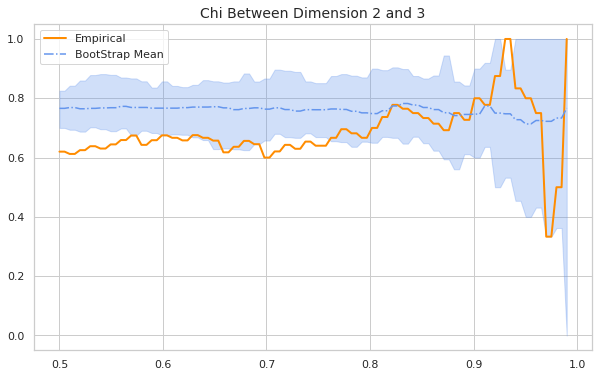

In [214]:
plot_tail_dependence(samples, i=1, j=2, model=model, n_bootstrap= n_bootstrap)

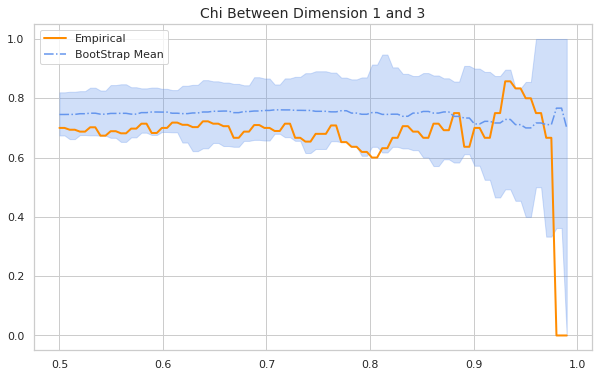

In [200]:
plot_tail_dependence(samples, i=0, j=2, model=model, n_bootstrap= n_bootstrap)

In [29]:
def empirical_cdf_vectorized(X):
    # X has shape (n, d)
    # We want to compare every pair of rows:
    #   - X[None, :, :] has shape (1, n, d)
    #   - X[:, None, :] has shape (n, 1, d)
    # For each pair (i,j), we check if X[j] <= X[i] componentwise.
    M = np.all(X[None, :, :] < X[:, None, :], axis=2)
    # Now, for each row i, the empirical CDF is the fraction of j such that M[i, j] is True.
    cdf = np.mean(M, axis=1)
    return cdf

def multivariate_CTE_1(X,p):
    ind_exceed_p = empirical_cdf_vectorized(X)>p
    X_exceed_p = X[ind_exceed_p,:]
    return np.mean(X_exceed_p, axis = 0)

In [30]:
samples_obs, samples_std, samples_T= model.sample(10000)
sampled_data = samples_obs.cpu().data.numpy()


In [31]:
prob_exceed = samples.shape[0]/samples_origin.shape[0]
prob_non_exceed = 1 - prob_exceed

p = 0.995
p_GPD = (p - prob_non_exceed)/prob_exceed

CET_1_pred = multivariate_CTE_1(sampled_data,p_GPD) + thres
CET_1_pred

array([[0.53532775, 0.75275177, 0.29444925, 0.35507412, 0.39188048]])

In [32]:
CET_1_emp = multivariate_CTE_1(samples_origin,p)

In [97]:
sum(np.any(samples_origin>thres,axis=1))

np.int64(233)

In [120]:

q- thres

array([[1.80991609, 2.02305587, 1.94240687]])

In [33]:
def multivariate_CTE_2(X,q):
    ind_exceed_p = np.any(X > q, axis=1)
    X_exceed_p = X[ind_exceed_p,:]
    return np.mean(X_exceed_p, axis = 0)

q = np.quantile(samples_origin,0.995,axis=0)
CET_2_emp = multivariate_CTE_2(samples_origin, q )
print(CET_2_emp)

CET_2_pred = multivariate_CTE_2(sampled_data, q- thres) + thres
print(CET_2_pred)


[0.34869356 0.47088554 0.20947322 0.23079541 0.23830503]
[[0.36726099 0.49225375 0.20955161 0.25680671 0.26779844]]


In [141]:
CTE_emp

[array([2.27131472, 2.2070957 , 2.17996701]),
 array([2.32653313, 2.24741802, 2.21781727]),
 array([2.42189002, 2.29918926, 2.27411676]),
 array([2.44238024, 2.36429733, 2.3354141 ]),
 array([2.49311014, 2.4321989 , 2.37689322]),
 array([2.60180662, 2.49416881, 2.51872467]),
 array([2.71669959, 2.65874631, 2.59091833]),
 array([2.92937534, 2.88061109, 2.74459906]),
 array([3.23319322, 3.23505238, 3.01892391]),
 array([3.56999408, 3.61968849, 3.19030554])]

In [187]:
thres.flatten().shape

(3,)

Text(0.5, 1.0, 'Type 1 CET of X5')

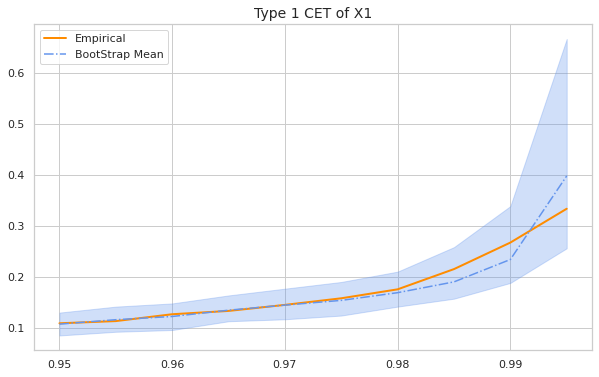

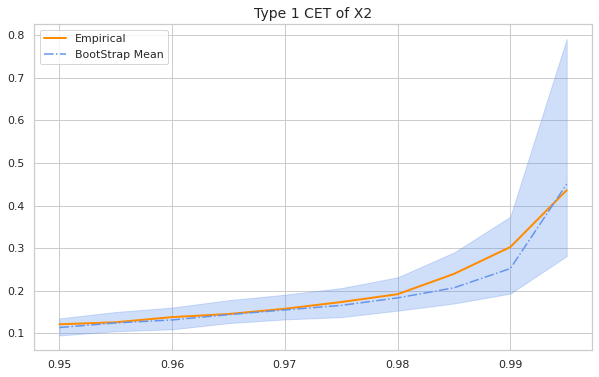

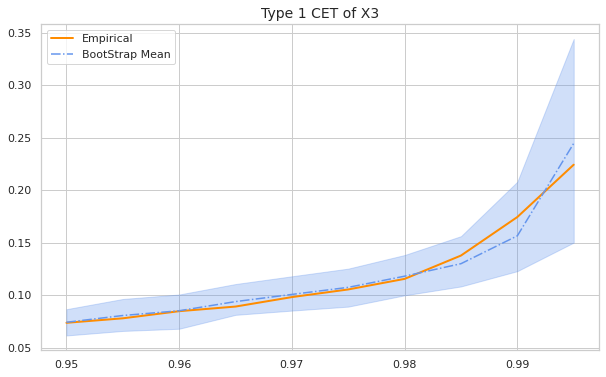

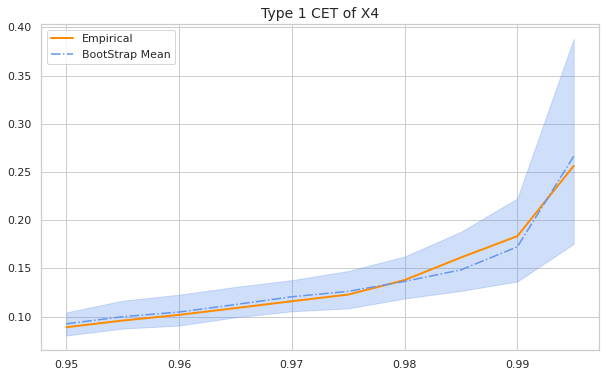

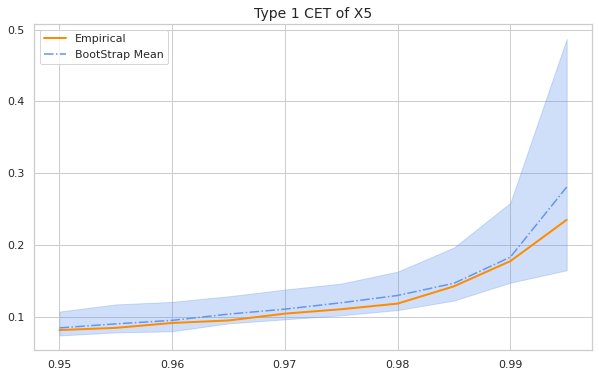

In [210]:
probs = np.linspace(0.95, 0.995, 10)
CET_function = multivariate_CTE_2

quantile = [np.quantile(samples_origin,p,axis=0) for p in probs]

CTE_emp = [CET_function(samples_origin, q) for q in quantile]
CTE_emp = np.stack(CTE_emp, axis=0)

# Step 2: Generate samples and compute their KDEs
n_samples = samples.shape[0]
sample_CET = []

for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
    samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
    sampled_data = samples_obs.cpu().data.numpy()
    sample_CET.append( [CET_function(sampled_data, q-thres) + thres.flatten() for q in quantile])


# Step 3: Calculate the 95% credible interval for the KDE of the samples
sample_CET = np.stack(sample_CET, axis=0)
lower_bound = np.percentile(sample_CET, 2.5, axis=0)
upper_bound = np.percentile(sample_CET, 97.5, axis=0)
mean = np.mean(sample_CET, axis=0)

# Step 4: Plot the KDE of the data and the credible intervals with Seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,0], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,0], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,0], upper_bound[:,0], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 1 CET of X1', fontsize=14)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,1], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,1], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,1], upper_bound[:,1], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 1 CET of X2', fontsize=14)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,2], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,2], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,2], upper_bound[:,2], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 1 CET of X3', fontsize=14)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,3], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,3], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,3], upper_bound[:,3], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 1 CET of X4', fontsize=14)


fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,4], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,4], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,4], upper_bound[:,4], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 1 CET of X5', fontsize=14)

In [105]:
def multivariate_CTE_3(X,q):
    ind_exceed_p = np.all(X > q, axis=1)
    X_exceed_p = X[ind_exceed_p,:]
    return np.mean(X_exceed_p, axis = 0)

q = np.quantile(samples_origin,0.95,axis=0)
CET_3_emp = multivariate_CTE_3(samples_origin, q)
print(CET_3_emp)

CET_3_pred = multivariate_CTE_3(sampled_data, q- thres) + thres
print(CET_3_pred)



[0.26412807 0.32273284 0.14945943 0.18494387 0.20295251]
[[0.21761412 0.23839093 0.13408123 0.15113092 0.15334826]]


Text(0.5, 1.0, 'Type 2 CET of X5')

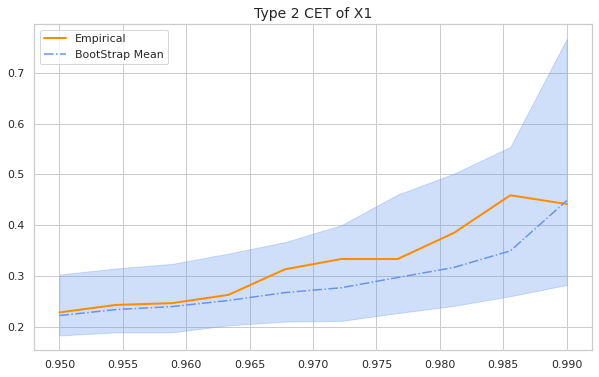

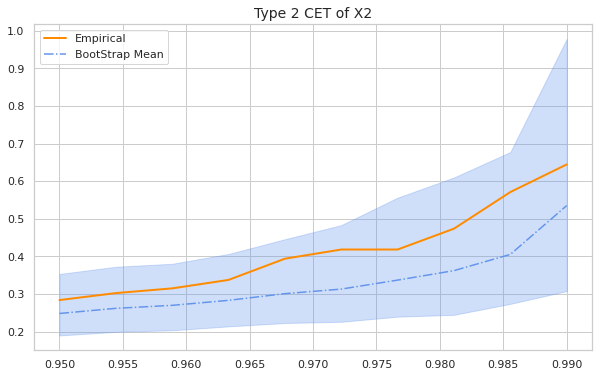

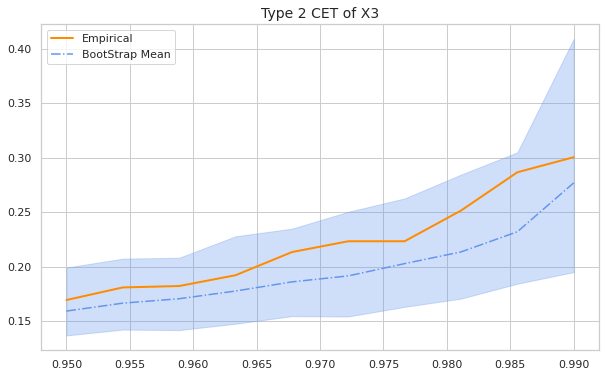

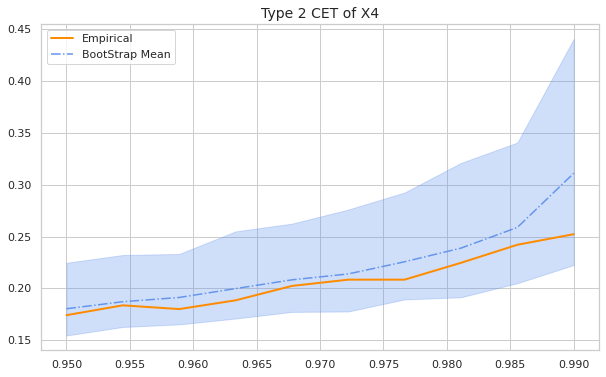

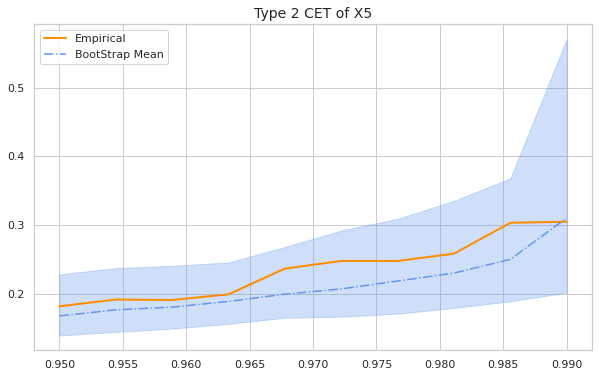

In [203]:
probs = np.linspace(0.95, 0.99, 10)
CET_function = multivariate_CTE_3

quantile = [np.quantile(samples_origin,p,axis=0) for p in probs]

CTE_emp = [CET_function(samples_origin, q) for q in quantile]
CTE_emp = np.stack(CTE_emp, axis=0)

# Step 2: Generate samples and compute their KDEs
n_samples = samples.shape[0]
sample_CET = []

for _ in range(n_bootstrap):  # Step 3: Repeat 200 times
    samples_obs, samples_std, samples_T= model.sample(samples.shape[0])
    sampled_data = samples_obs.cpu().data.numpy()
    sample_CET.append( [CET_function(sampled_data, q-thres) + thres.flatten() for q in quantile])


# Step 3: Calculate the 95% credible interval for the KDE of the samples
sample_CET = np.stack(sample_CET, axis=0)
lower_bound = np.percentile(sample_CET, 2.5, axis=0)
upper_bound = np.percentile(sample_CET, 97.5, axis=0)
mean = np.mean(sample_CET, axis=0)

# Step 4: Plot the KDE of the data and the credible intervals with Seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,0], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,0], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,0], upper_bound[:,0], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 2 CET of X1', fontsize=14)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,1], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,1], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,1], upper_bound[:,1], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 2 CET of X2', fontsize=14)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,2], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,2], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,2], upper_bound[:,2], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 2 CET of X3', fontsize=14)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,3], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,3], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,3], upper_bound[:,3], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 2 CET of X4', fontsize=14)


fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=probs, y=CTE_emp[:,4], label='Empirical', color='darkorange', linewidth=2)
sns.lineplot(x=probs, y=mean[:,4], linestyle='dashdot', color='cornflowerblue', label='BootStrap Mean', linewidth=1.5)
ax.fill_between(probs, lower_bound[:,4], upper_bound[:,4], color='cornflowerblue', alpha=0.3, label='95% Credible Interval')
ax.set_title(f'Type 2 CET of X5', fontsize=14)